# Time Series Analysis of the Covid-19 pandemic in Mexico

In this post we will look at the time series workflow in python, looking at confirmed Covid-19 cases at the national and state level in Mexico. We will be following the [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) for fitting time series models; which in this case will be [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) models.

## Background
ARIMA stands for Auto Regressive Integrated Moving Average, these are 3 separate components:
- Auto Regressive (AR): these reffers to predicting the current observation based on $p$ previous ones. So an AR(1) model is:
$x_t = \beta x_{t-1} + \varepsilon_t $. 
- Moving Average (MA): these accounts for the correlation between the current observation and the previous $q$ errors (difference between predicted values with an AR model and the actual data). 
- Integrated (I): this is the number of times we take the difference of the series (i.e substracting the previous observation to the current one). It's often done to work with a stationary series. Ex.: $x_t-x_{t-1} = \beta(x_{t-2}-x_{t-3}) + \varepsilon_t$.

ARIMA models requires a few assumptions on the data:
- The time series is stationary, this means that the the mean and variance of the distribution from which the data is generated must stay cconstant in time. 
- The residuals are i.i.d normal, this means that they aren't auto-correlated and they have equal variance (similar to the linear regression assumption).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exploratory Data Analysis
The data of daily cases is made available by the Ministry of Health and the Council for Science and Technology ([Conacyt](https://datos.covid-19.conacyt.mx/)). The dataframe was downloaded and stored on github; its columns represent days and rows are Mexican states. 

In [5]:
daily_cases = pd.read_csv("https://raw.githubusercontent.com/abraham-mv/Covid-19-in-Mexico-time-series/main/Casos_Diarios_Estado_Nacional_Confirmados_20220109.csv")
daily_cases.tail()

,cve_ent,poblacion,nombre,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,...,2021-12-31,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09
28,29,1380011,TLAXCALA,0,0,0,0,0,0,0,...,12,7,15,46,79,66,103,67,15,0
29,30,8539862,VERACRUZ,0,0,0,0,0,0,0,...,83,28,68,215,238,255,252,169,31,0
30,31,2259098,YUCATAN,0,0,0,0,0,0,0,...,295,49,73,629,711,784,715,574,52,0
31,32,1666426,ZACATECAS,0,0,0,0,0,0,1,...,218,58,76,465,609,697,711,410,218,0
32,0,127792286,Nacional,0,4,2,2,2,5,9,...,9453,2969,4668,19513,24564,26464,23679,15790,4284,67


We'll mainly focus on the national level first, let's take a look at our time series.

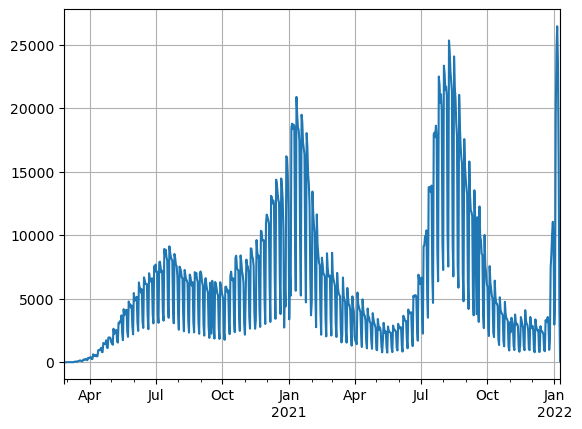

In [6]:
import matplotlib.pyplot as plt
#daily_cases = pd.read_csv("https://datos.covid-19.conacyt.mx/Downloads/Files/Casos_Diarios_Estado_Nacional_Confirmados_20230625.csv")
nation = daily_cases.iloc[-1,:].drop(["cve_ent", "poblacion", "nombre"], axis=0)
nation.name = "National"
nation.index = pd.to_datetime(nation.index, infer_datetime_format=True)
nation.plot()
plt.grid()

We can see three clear peaks in daily cases, corresponding to the first 3 waves of the pandemic in the country. The time series shows highly perdiodic behaviour let's decompose the first 150 observations into its trend seasonal and residual parts. 

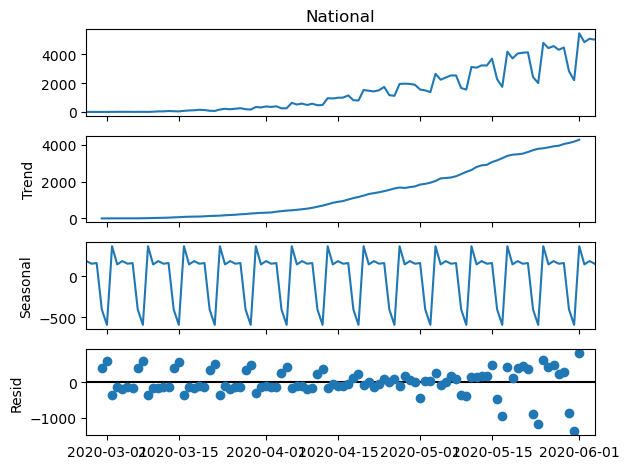

In [133]:
seasonal_decompose(nation[:100]).plot()
plt.show()

There's a clear upward trend in the beginning of the pandemic, we can also see strong seasonality in the data, and the residuals also show some periodicity. This seasonality might be due to a lack of staff members collecting patient information during weekends rather than an actual drop in cases. What's often done for these type of time series is to smooth them using moving average; this smoothing technique takes the average of the last $n$ observations. Given that the drop in cases appears to be weekly we should use a window of 7 days or any multiple of 7 for that matter.

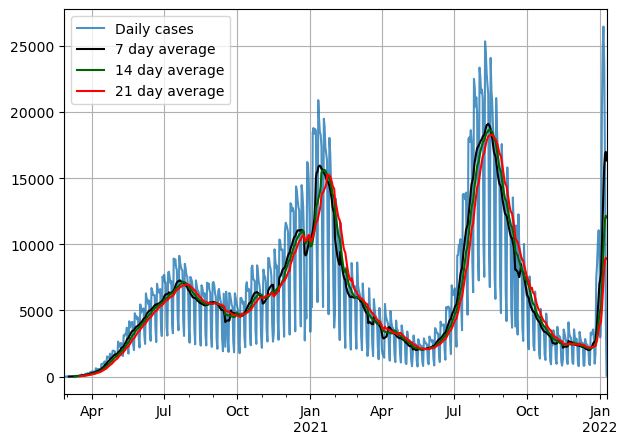

In [8]:
X_sma_7 = nation.rolling(window=7).mean().dropna()
X_sma_14 = nation.rolling(window=14).mean().dropna()
X_sma_21 = nation.rolling(window=21).mean().dropna()
plt.figure(figsize=(7,5),dpi=100)
nation.plot(label = 'Daily cases', alpha=0.8)
X_sma_7.plot(color = 'black',label = '7 day average')
X_sma_14.plot(color = 'darkgreen', label = '14 day average')
X_sma_21.plot(color = 'red', label = '21 day average')
plt.grid()
plt.legend()
plt.show()

Important to note that as we increase the window the series becomes much smoother.

## Data transformations and model selection

The next step in the time series workflow is model selection. When using ARIMA models is common practice to determine the coefficients with the plots of the Autocorrelation and Partial Autocorrelation Functions ([ACF](https://en.wikipedia.org/wiki/Autocorrelation) & [PACF](https://en.wikipedia.org/wiki/Partial_autocorrelation_function)). The former is just the correlation between the series and itself in the past, the latter is the autocorrelation between the residuals of an auto-regressive model. These plots are also very useful to look for patterns in the data and determine if the series is stationary.

For the sake of this excercise we will cutoff the series for training on July 1st, 2021, when cases were on the rise and forecasting future daily cases was of general interest. 

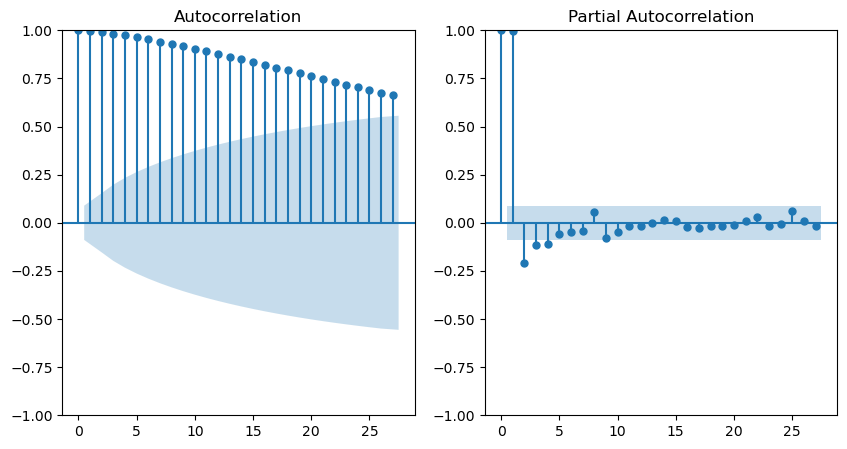

In [249]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train = X_sma_7[X_sma_7.index < pd.to_datetime('2021-07-01')]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)
axes = axes.ravel() 
plot_acf(train, ax=axes[0])
plot_pacf(train, ax=axes[1])
plt.show()

For the smooth series we can see that the ACF is decreasing, while for the PACF we have significant peaks at lags 1 and 2. This means that the series is mostly dependent on the previous 2 days; therefore, best model would be an AR(2). To induce stationary we often take one or two differences. We can also do other transformations like taking the log or square root of the series to minimize the effect of extreme values. Let's look at this transformed series.

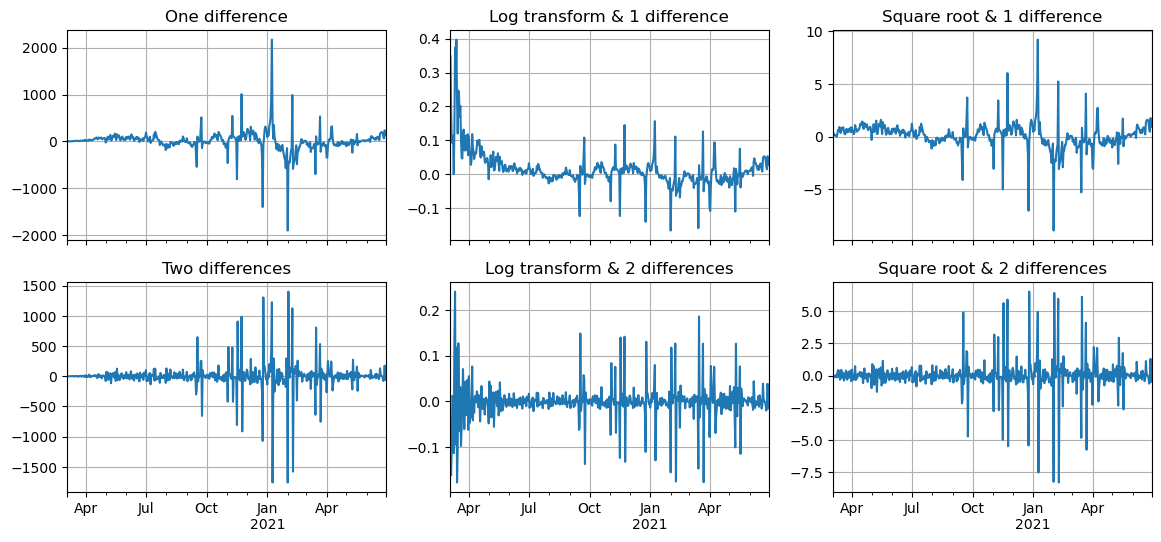

In [227]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 6), sharex=True)
axes = axes.ravel() 
train.diff().plot(ax = axes[0], title="One difference", grid=True)
np.log(train).diff().plot(ax = axes[1], title="Log transform & 1 difference", grid=True)
np.sqrt(train).diff().plot(ax = axes[2], title="Square root & 1 difference", grid=True)
train.diff().diff().plot(ax = axes[3], title="Two differences", grid=True)
np.log(train).diff().diff().plot(ax = axes[4], title="Log transform & 2 differences", grid=True)
np.sqrt(train).diff().diff().plot(ax = axes[5], title="Square root & 2 differences", grid=True)
plt.show()

It's evident that with just one difference the mean of the series still varies with time, this effect is solved by taking an additional difference. However, the variance of the series still changes, even after taking log or square root transformations. Looking at this graphs it's possible that the best way forward is the log transformation + second order integration (2 differences). 

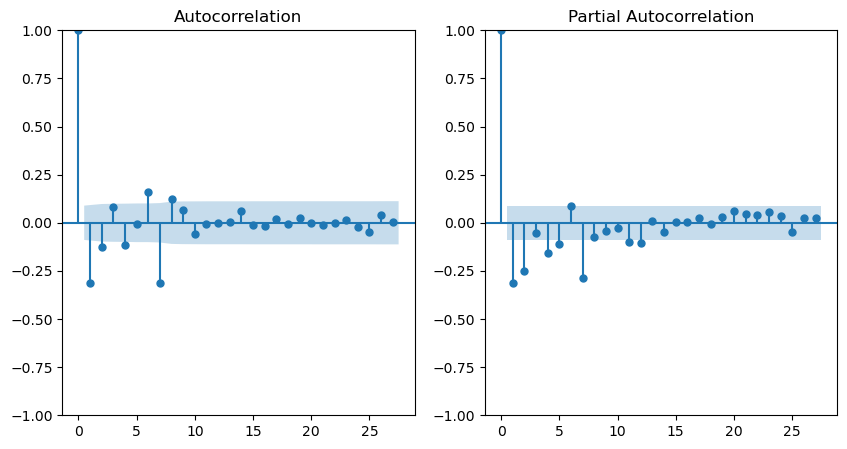

In [250]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)
axes = axes.ravel()
plot_acf(np.log(train).diff().diff().dropna(), ax=axes[0])
plot_pacf(np.log(train).diff().diff().dropna(), ax=axes[1])
plt.show()

Looking at the ACF and PACF plots for this transformed series, we may be looking at an ARMA process here. 

## Model Fitting and validation
To determine the exact order of the ARIMA model we use the `auto_arima` function from the `pmdarima` package. This function will quickly fit models and compute the AIC, the model with the highest AIC is selected.

In [231]:
import pmdarima
arima_model = pmdarima.arima.auto_arima(np.log(train), d=2)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  485
Model:               SARIMAX(1, 2, 1)   Log Likelihood                 930.381
Date:                Tue, 29 Aug 2023   AIC                          -1854.762
Time:                        13:07:28   BIC                          -1842.222
Sample:                             0   HQIC                         -1849.834
                                - 485                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3424      0.034     10.181      0.000       0.276       0.408
ma.L1         -0.8842      0.024    -36.850      0.000      -0.931      -0.837
sigma2         0.0012   3.64e-05     34.120      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              1859.44
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.25
Prob(H) (two-sided):                  0.09   Kurtosis:                        12.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The function suggest an ARMA(1,1) on the second order integrated and log-transformed series, without any seasonality component. Important to note the following:  
- The coefficients for the AR and MA components are both statistically significant. 
- The Ljung-Box test is showing a p-value greater than 0.05,  we fail to reject the null-hypothesis that the residuals are independent (although we should expect something closer to 0.99 in a better model).
- The heteroskedasticity test is showing a p-value greater than 0.05, therefore we can't reject the null-hypothesis that the error variances are independent (again we would expect to have a higher p-value in a better model).

We can look at many tests, but it's also useful to just look at the graph and check if the model assumptions seem valid.

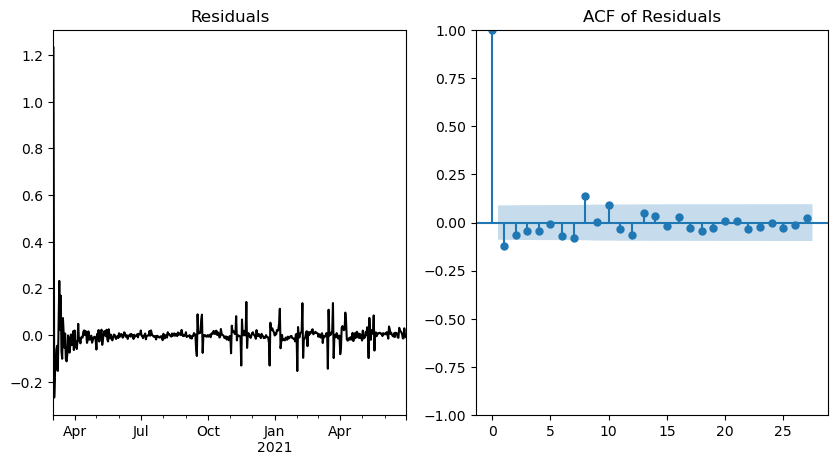

In [256]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()
pd.Series(arima_model.resid(), index=train.index).plot(color="black", ax=axes[0], title="Residuals")
plot_acf(arima_model.resid(), title="ACF of Residuals", ax=axes[1])
plt.show()

From this graph we can clear see that although the mean appears to be independent from the time there are periods where the variance is higher, therefore we have some heteroskedasticity, with a perfect model we'd expect Gaussian noise behavior. The ACF plot is showing a few significant peaks at lags 1 and 8, which isn't ideal and further confirms that the residuals might be somewhat correlated. Although this is by no means a perfect model, it's probably as good as it gets for this data.

## Forecasting
We will use the model to predict 30 days in the future.

In [235]:
test = X_sma_7[X_sma_7.index >= pd.to_datetime('2021-07-01')][:35]
prediction, confint = arima_model.predict(n_periods=35, return_conf_int=True)
prediction

array([8.52809307, 8.55922593, 8.59075826, 8.62242736, 8.65414329,
       8.68587525, 8.7176127 , 8.74935204, 8.78109201, 8.81283221,
       8.84457248, 8.87631278, 8.90805309, 8.9397934 , 8.97153371,
       9.00327402, 9.03501433, 9.06675464, 9.09849496, 9.13023527,
       9.16197558, 9.19371589, 9.2254562 , 9.25719652, 9.28893683,
       9.32067714, 9.35241745, 9.38415776, 9.41589808, 9.44763839,
       9.4793787 , 9.51111901, 9.54285932, 9.57459964, 9.60633995])

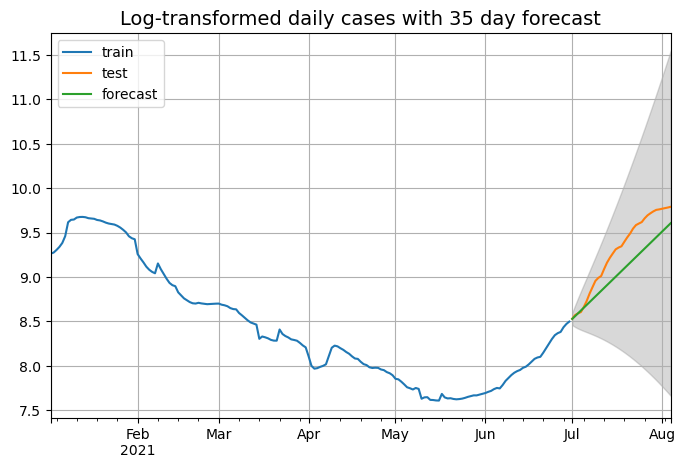

In [248]:
cf= pd.DataFrame(confint)
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
np.log(train[-180:]).plot(ax=ax, label="train")
np.log(test).plot(ax=ax, label="test")
ax.plot(prediction_series, label="forecast")
ax.legend(loc="upper left")
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3, label="CI")
ax.set_title("Log-transformed daily cases with 35 day forecast", fontsize=14)
ax.grid()

As we can see the model is succesfully able to capture the upward trend ot the series, but a major limitation of these models is their unability to determine when a peak is coming. 